  # **Home Credit Default Risk Prediction**


Home Credit Default Risk - Exploration + Baseline Model
Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders. Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

In this notebook, we will take an initial look at the Home Credit default risk machine learning competition currently hosted on Kaggle. The objective of this competition is to use historical loan application data to predict whether or not an applicant will be able to repay a loan. 
competition link :[https://www.kaggle.com/competitions/home-credit-default-risk](https://www.kaggle.com/competitions/home-credit-default-risk)

## 1.Data Overview:

<strong>application_{train|test}.csv:</strong> <br>The main table, with static data for all loan applications in the sample. This table is split into two files, one for the training set (which includes the target variable) and one for the test set (which does not include the target variable).<br>
<strong>bureau.csv:</strong> <br>Data on all previous loans provided by other financial institutions that were reported to Credit Bureau for clients who have a loan in the Home Credit sample. There is one row for every loan in the Home Credit sample, and multiple rows for each client's previous loans in Credit Bureau.<br>
<strong>bureau_balance.csv:</strong> <br>Monthly balances of previous credits in Credit Bureau. This table has one row for each month of history of every previous credit reported to Credit Bureau.<br>
<strong>POS_CASH_balance.csv:</strong> <br>Monthly balance snapshots of previous POS and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit related to loans in the sample.<br>
<strong>credit_card_balance.csv:</strong> <br>Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit related to loans in the sample.<br>
<strong>previous_application.csv:</strong> Data on all previous applications for Home Credit loans of clients who have loans in the Home Credit sample. There is one row for each previous application related to loans in the sample.<br>
<strong>installments_payments.csv:</strong> Repayment history for previously disbursed credits in Home Credit related to the loans in the sample. There is one row for every payment that was made, plus one row for each missed payment.<br>
<strong>HomeCredit_columns_description.csv</strong>
This file contains descriptions for the columns in the various data files.



![Home_Credit_Schema](Home_Credit_Schema.png)

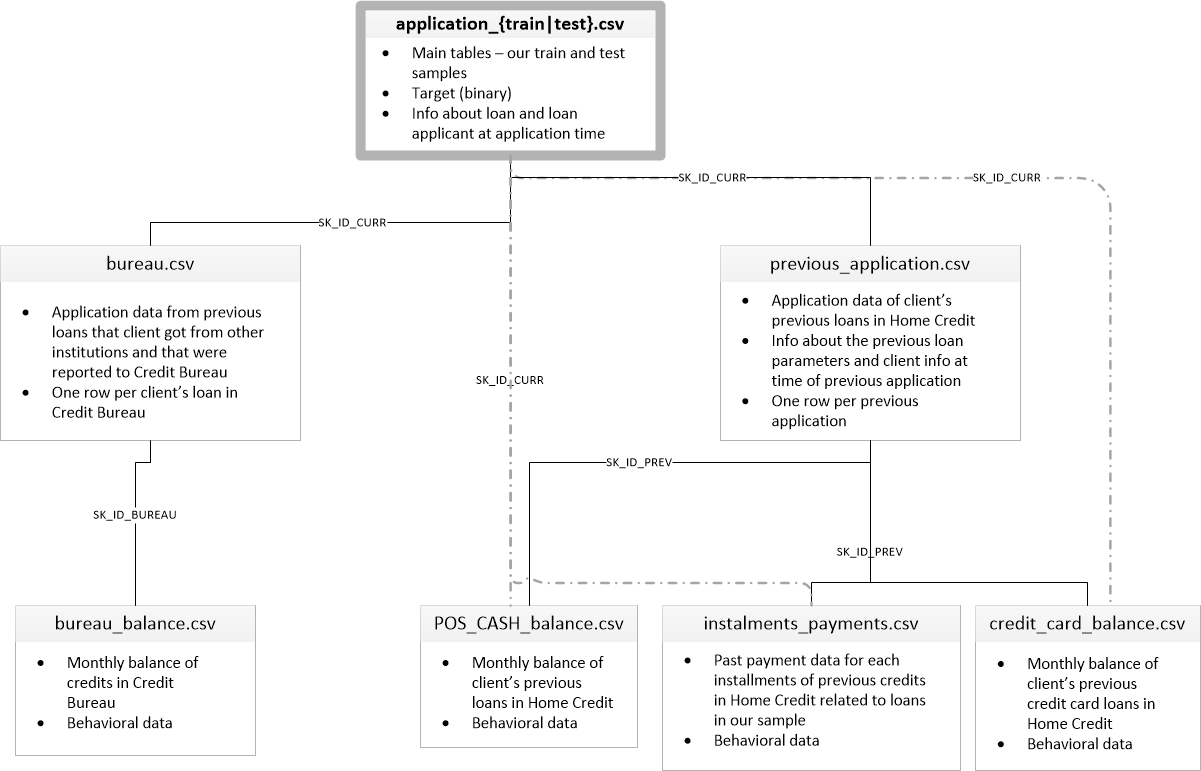
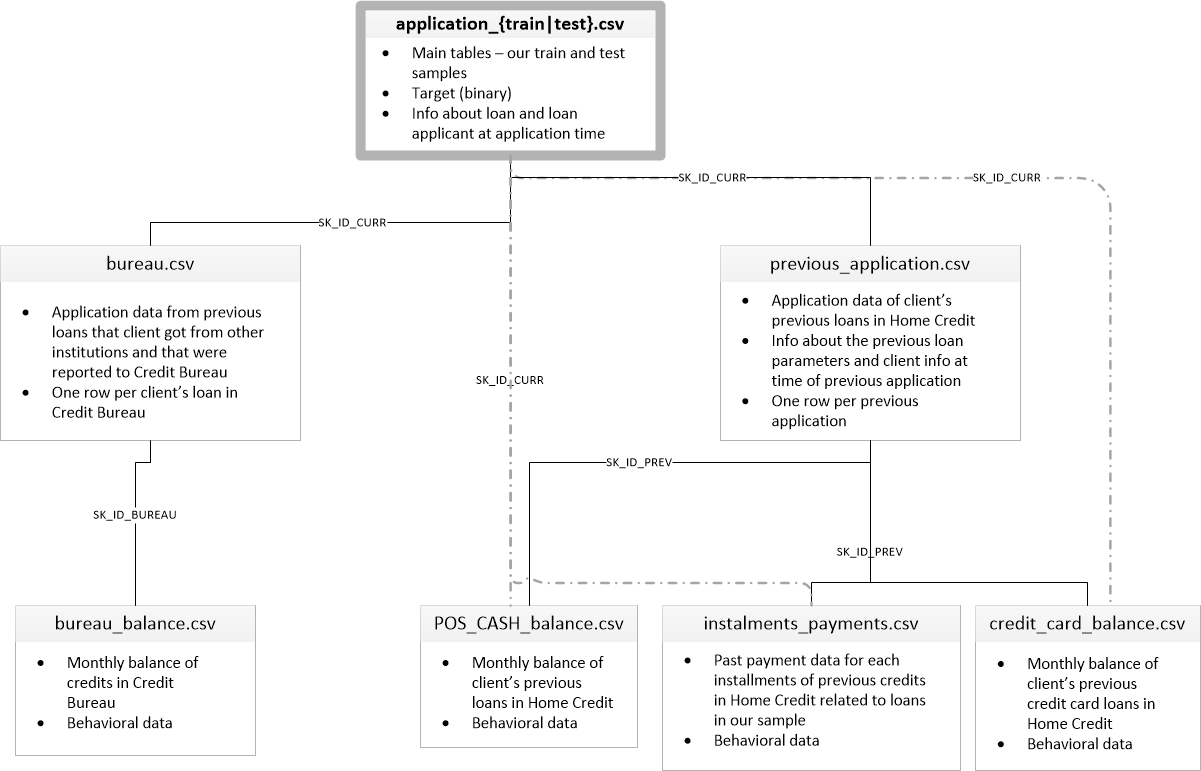

It seems a challenging competition with more than dataframe  and it may take a lot of time to produce the final solution .<br>
in this notebook we will stick only to the main file `application_train` and the testing data `application_test` . This will let us establish a baseline that we can then improve upon by other files via feature engineering techniques for further improvement to build reliable and consistent model that can perform well to unseen data. Don't worry about now about other files ,I will show you the way to explore,handle and turn them into insightful features to improve the Baseline that we tend to build in this notebook.

# 1.1.Load Packages :

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from numpy.random import randint
from multiprocessing import cpu_count
import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.linear_model import LogisticRegression ,SGDClassifier
from sklearn.preprocessing import FunctionTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline #pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE #for feature selection
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.metrics import (f1_score,classification_report,
                             roc_auc_score,confusion_matrix,roc_curve,auc) # evaluatin metrics
from sklearn.model_selection import KFold,RandomizedSearchCV ,cross_val_score,RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
import gc

# 2.Exploratory Data Analysis:

Exploratory Data Analysis aims to more understanding of the data, it give us useful information about the data we are working with in wich we decide the wich process is better for modeling.I start with a high level overview ,then narrows into specific areas(anomalies,missing data,patterns...).

## 2.1 Read Data:

data is very big ,let's reduce memory usage to speed up trainnig and processing steps.This helpfull function will reduce memory by 70%.

In [3]:

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)


    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def import_data(file):
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df


In [53]:
application_train = import_data('../input/home-credit-default-risk/application_train.csv')
application_test = import_data('../input/home-credit-default-risk/application_test.csv')

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%


## 2.2.Data Overview :

In [5]:
pd.set_option('display.max_rows', 30)
def info(table):
    print(f'\n the shape of the table is : \n',table.shape)
    print('-' * 80)
    print('\n data types : ', table.dtypes.value_counts().sort_values())
    print('-' * 80)
    missings=table.isna().mean()[table.isna().mean().sort_values(ascending=False)!=0].sort_values(ascending=False)
    print('-' * 80)
    print('\n number of features having missing data : ',len(missings))
    print('-' * 80)
    print('\n missing data in the table: \n',missings)
    print('-' * 80)
    print(missings[missings>0.5])
    print('-' * 80)
    print('\n missing data over 50% : ',len(missings[missings>0.5]))
info(application_train)    



 the shape of the table is : 
 (307511, 122)
--------------------------------------------------------------------------------

 data types :  int32       2
int16       2
float32     4
object     16
int8       37
float16    61
dtype: int64
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------

 number of features having missing data :  67
--------------------------------------------------------------------------------

 missing data in the table: 
 COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
                              ...   
EXT_SOURCE_2                0.002146
AMT_GOODS_PRICE             0.000904
AMT_ANNUITY                 0.000039
CNT_FAM_MEMBERS             0.000007
DAYS_LAST_PHONE_CHANGE      0.000003
Length: 67, dtype: float64
-----

The data we are working with contains`307511` observations and `122` columns only 16 of them are categorical and the rest are numeric .<br>
But the problem we are facing here is the huge amout of **missing data** with **67** columns contains missing informations with proportion more than **60%** exceed threshold of 50% of missingness .<br>
To tackle this problem we should do further analysis and select best strategies to handle them ,so let's start with the analysis first and keep this task to the processing step.

## 2.3.Examine the Target:

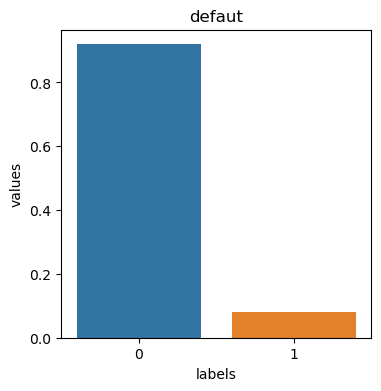

In [6]:
temp = application_train.TARGET.value_counts()
df1 = pd.DataFrame({'labels': temp.index,
                   'values': temp.values/len(application_train)})
plt.figure(figsize = (4,4))
plt.title('defaut')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df1)
locs, labels = plt.xticks()
plt.show()

From the distribution plot of the **TARGET** column we notice than our data suffers from imbalanced classes , There are far more loans that were repaid on time than loans that were not repaid.This may affect the model and results in biased predictions toward the non default class.It's important to choose the right option to handle this issue before running model.

## 2.4.Numeric features:

Let's now deep into more details by exploring th distributions of numeric features ,this may be informative way and help in identifying of hidden patterns and relationships in the data.<br>
We will plot numeric features distributions along with the target to show patterns.

In [7]:
NUMERIC_FEATURES = application_train.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']).columns


In [8]:
application_train[NUMERIC_FEATURES].describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.0,265992.0,265992.0,265992.0,265992.0,265992.0
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990259e+05,27108.572266,5.383961e+05,0.000000,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.0,0.0,0.0,NaN,NaN,NaN
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737305,3.694465e+05,0.000000,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.0,0.0,0.0,0.0,NaN,0.0
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010010,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018845,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028656,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,3.0
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072510,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.0,9.0,8.0,27.0,261.0,25.0


From this dataframe numeric features are not well identified and contains categorical features representent as numerical ones and these are : <br>
- **SK_ID_CURR** is an index not feature .
- **TARGET** ,**children** represents the number of children the applicant have. <br>
- **FLAG_DOCUMENT_2**, **FLAG_DOCUMENT_3**, .... **FLAG_DOCUMENT_20** ,**FLAG_DOCUMENT_21** :These features are binary flags indicating the presence or absence of specific documents in the applicant's file. Each flag represents a different type of document (e.g., identification documents, income documents, etc.)<br>

another finding is that the group :<br>
**AMT_REQ_CREDIT_BUREAU_HOUR**,**AMT_REQ_CREDIT_BUREAU_DAY**,**AMT_REQ_CREDIT_BUREAU_WEEK**,**AMT_REQ_CREDIT_BUREAU_MON**, **AMT_REQ_CREDIT_BUREAU_QRT**,**AMT_REQ_CREDIT_BUREAU_YEAR** represent the number of inquiries or requests made to the Credit Bureau by the applicant within specific time intervals. Each feature corresponds to a different time unit (hour, day, week, month, quarter, year).

### 2.4.1 hypothesis and questions :

Now you get to explore this exciting dataset! Can't think of where to start ? let's think like experts and and start with asking some usefull questions,put hypothesis about the main causes of the default that we tend to test and answer them in order to  identify trends, outliers, potential feature interactions, or nonlinear associations that may influence credit default predictions.:<br>

- does a large amout of credit leads to default ?<br>
- May the huge annuity to repay is the main cause of the default?<br>
- does the number of children have an impact on the credit default ?<br>
- Does the number of days employed , age of the applicant have a negative impact to the repayment ?<br>
- Does the high price of the goods for which the loan is requested causes the default to pay?<br>
- Is the limited amount of income the principle factor of default ?<br>

answering these questions will help us to identify potential features and choose the best strategy to process them.So let's explore these features :<strong>DAYS_BIRTH,DAYS_EMPLOYED,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE</strong>.

### 2.4.2.Vusialisation :

In [9]:
def plot_distribution(df, FEATURES):
    i = 0
    t1 = df.loc[df['TARGET'] != 0]
    t0 = df.loc[df['TARGET'] == 0]

    sns.set_style('whitegrid')
    fig, ax = plt.subplots(4, 2, figsize=(16, 20))

    for feature in FEATURES:
        if feature != 'TARGET':
            i += 1
            plt.subplot(4, 2, i)
            sns.kdeplot(t1[feature], bw=0.5, color='red', label="TARGET = 1")
            sns.kdeplot(t0[feature], bw=0.5, label="default = 0")
            plt.ylabel('Density plot', fontsize=12)
            plt.xlabel(feature, fontsize=12)
            plt.xticks(fontsize=12, rotation=90)  # Set the font size for x-axis labels
            plt.yticks(fontsize=12)  # Set the font size for y-axis labels

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()


In [10]:
domain_features=['AMT_CREDIT','AMT_ANNUITY','DAYS_BIRTH','DAYS_EMPLOYED','AMT_INCOME_TOTAL','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE']

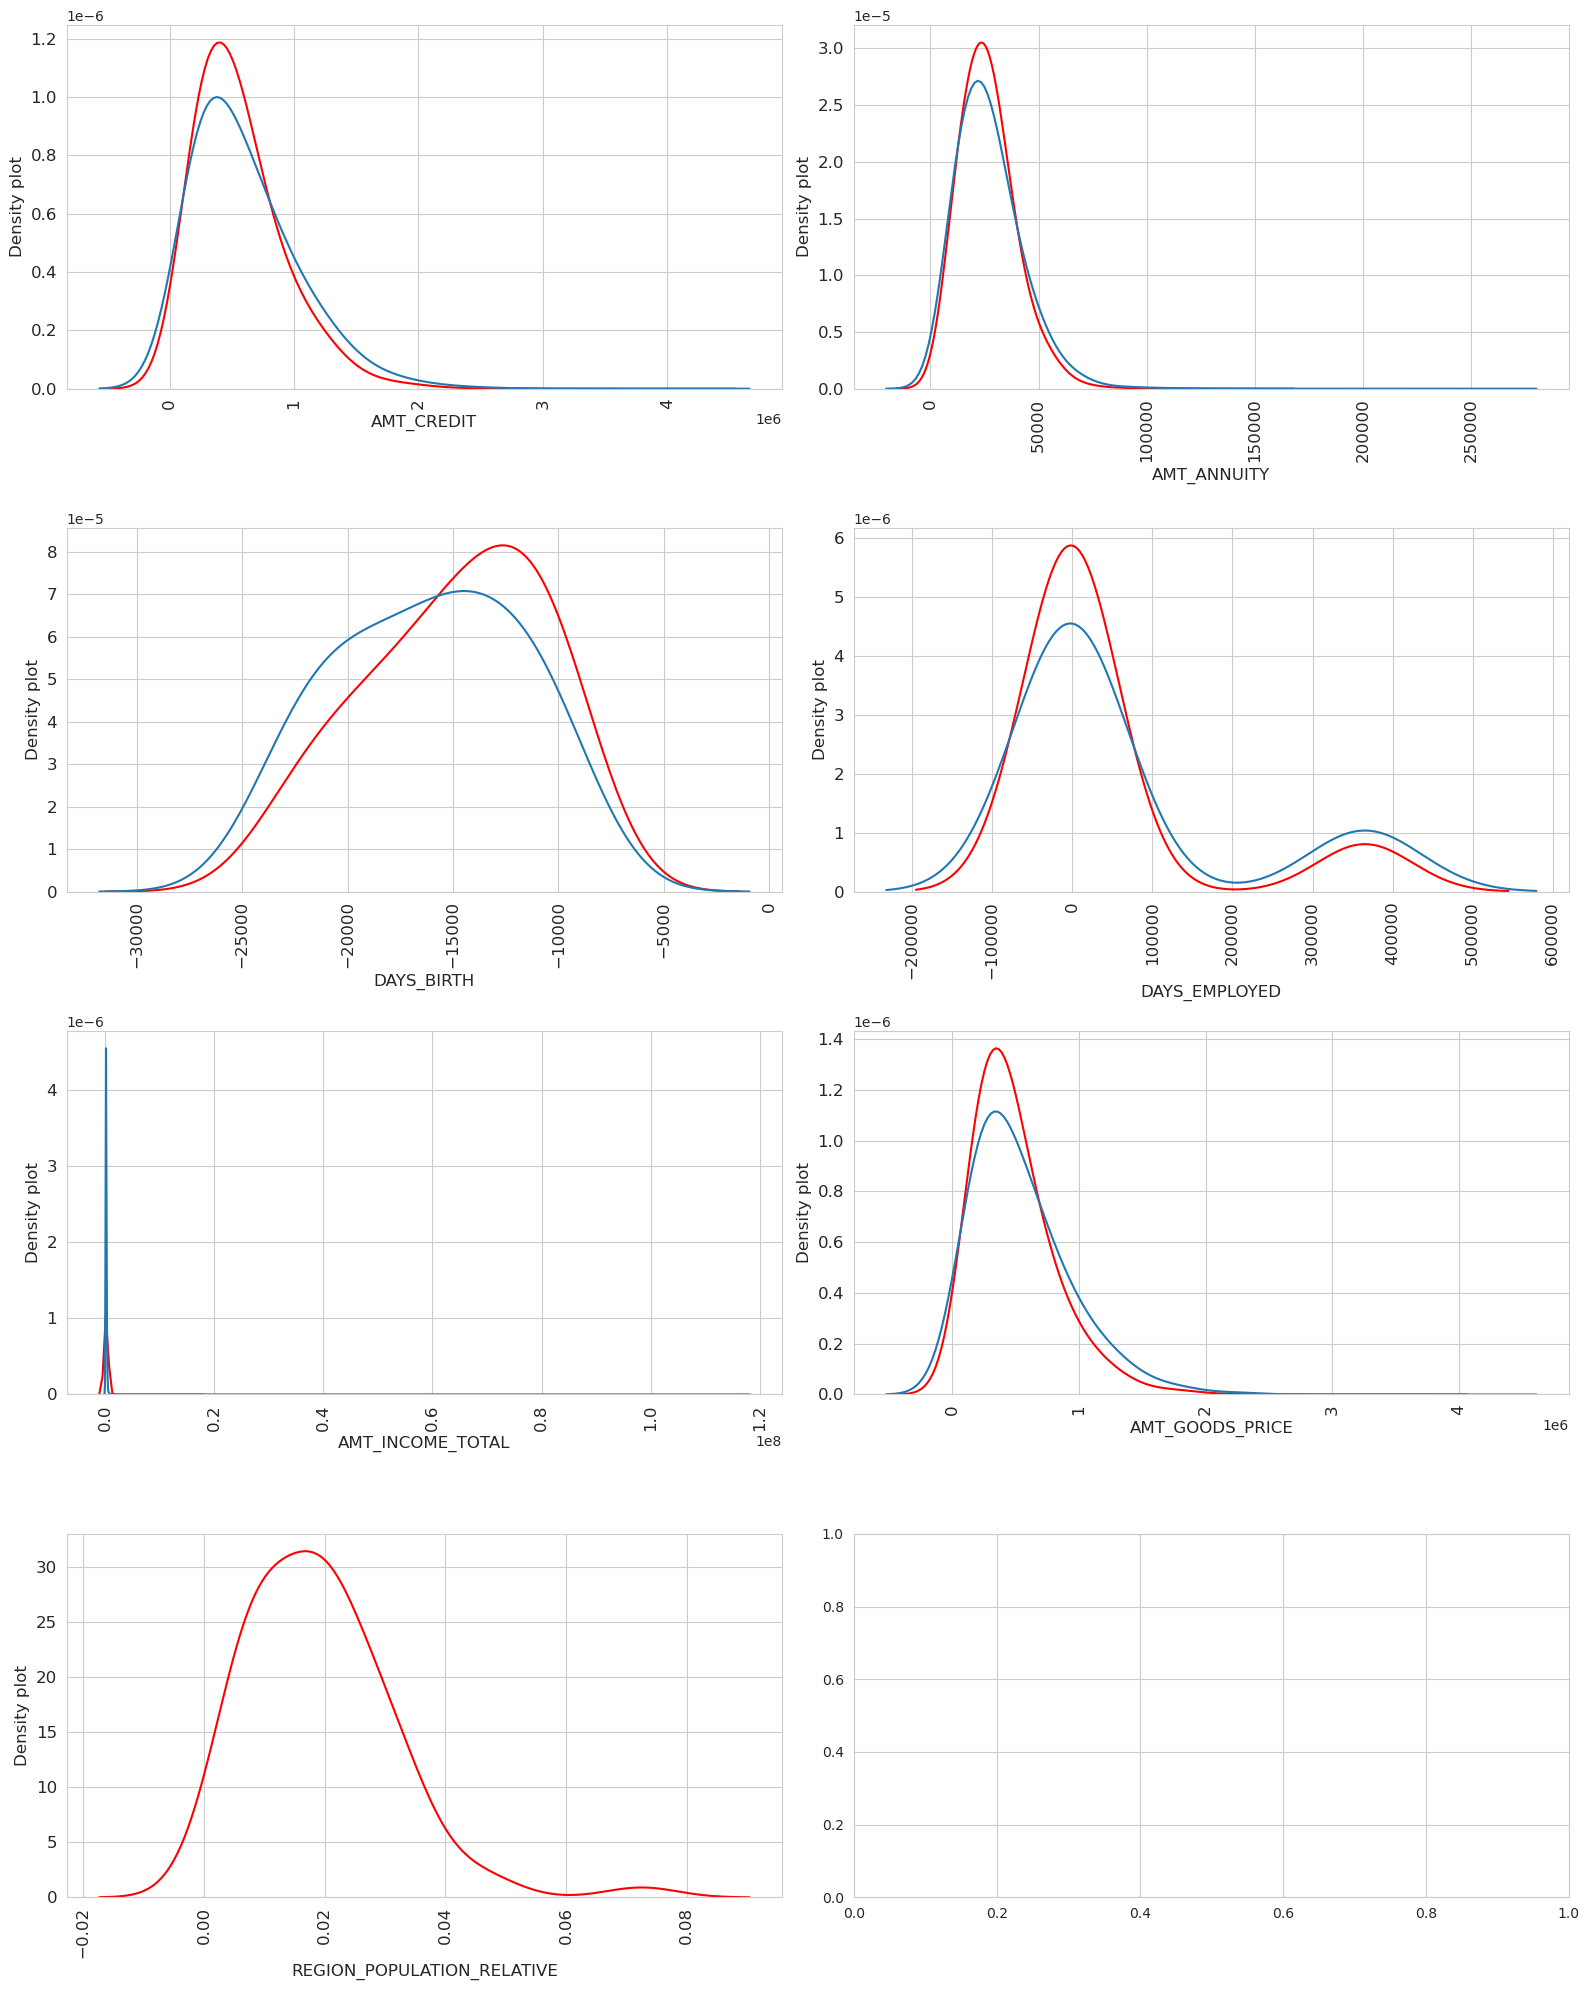

In [11]:
plot_distribution(application_train,domain_features)

### 2.4.3.Inetrpretetion :

Well !we can now ansewr the questions from the distributions of the features:<br>
- for the first question we can say that the large amount of credit is not the cause of defaulting and we can explain this by the hard procedures that banks uses for large loans .Also from this plot we find that most of the defaulters have small credits less than one Million Dollar because Banks doesn't put in place complicated procedures to control the small loans as for big loans .<br>
- for the second question The similarity in the shape and mean of the annuity distribution between default==1 and default==0 suggests that, on average, the annuity values for both groups are comparable. This similarity indicates that the average annuity amounts are not significantly different between borrowers who defaulted and those who did not.Also,there is higher likelihood of default cases in the central region. This suggests that there might be an increased likelihood of default for borrowers with annuity values around the peak of the distribution.<br>
- for the third question The target == 1 curve skews towards the younger end of the range,younger peope are more likely to default. The distribution of the days_employed indicates that new employees are more likely to make default. <br>
- for the income it's very noisy and contains many outliers we will use the boxplot just above to interpret it, from the boxplot there is no pattern to borrowers who make default.

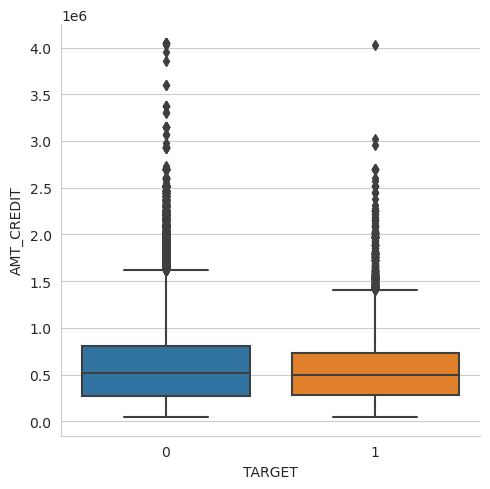

In [12]:
sns.catplot(application_train.drop(application_train.AMT_INCOME_TOTAL.argmax())
,x='TARGET',y='AMT_CREDIT',kind='box');

### 2.4.4Correlation and relationships :

#### 2.4.4.1.Correlogram :

If we inspect more the numeric features we can find features:**'EXT_SOURCE_1**', **'EXT_SOURCE_2'**, and **'EXT_SOURCE_3'** are numerical features that represent external credit-related scores or indicators that may be very useful in the modeling task. these features can be valuable as they provide additional information beyond the applicant's internal credit information. They allow lenders or credit institutions to incorporate external data into their credit evaluation process, providing a more comprehensive view of the applicant's creditworthiness.So

In [13]:
EXT_SOURCE_TARGET=['EXT_SOURCE_1','EXT_SOURCE_2', 'EXT_SOURCE_3','TARGET']
application_train[EXT_SOURCE_TARGET].corr().style.format("{:.4}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,TARGET
EXT_SOURCE_1,1.0,0.214,0.1868,-0.1553
EXT_SOURCE_2,0.214,1.0,0.1092,-0.1605
EXT_SOURCE_3,0.1868,0.1092,1.0,-0.1789
TARGET,-0.1553,-0.1605,-0.1789,1.0


EXT_SOURCE features have small correlation between each other and they have small negative correlatons with the target .

#### 2.4.4.2**t_test** :

Hey! what if we want to compare the distributions with a more robust method ,so t_test is the best choice to detect the significant numeric features.We can determine the significance of the difference between the means of the two groups(default and non_default). If the p-value is below a chosen significance level (we will use 0.05), you can conclude that there is a statistically significant difference between the means of the groups.

In [14]:
def t_test(df):
    t_stat_list=[]
    p_val_list=[]
    variable=[]

    for var in df.columns:    
        t_stat, p_val = stats.ttest_ind(application_train[application_train['TARGET'] == 0][var],
                                        application_train[application_train['TARGET'] == 1][var])
        if p_val < 0.05:
            variable.append(var)
            t_stat_list.append(t_stat)
            p_val_list.append(p_val)

    t_test = pd.DataFrame({'variable': variable, 't_stat': t_stat_list, 'p_val': p_val_list})
    return t_test.sort_values(by='p_val',ascending=True)

In [15]:
t_test(application_train.select_dtypes(['int8','int16','float16','int32','float32','int64','float64']))


,variable,t_stat,p_val
0,TARGET,-inf,0.000000e+00
5,DAYS_BIRTH,-43.519836,0.000000e+00
12,REGION_RATING_CLIENT_W_CITY,-33.829889,2.078455e-250
11,REGION_RATING_CLIENT,-32.718363,2.172433e-234
7,DAYS_ID_PUBLISH,-28.572653,2.527524e-179
...,...,...,...
19,FLAG_DOCUMENT_2,-3.004040,2.664419e-03
23,FLAG_DOCUMENT_9,2.413585,1.579700e-02
24,FLAG_DOCUMENT_11,2.345343,1.901021e-02
2,AMT_INCOME_TOTAL,2.208106,2.723762e-02


DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,        DAYS_ID_PUBLISH REGION_POPULATION_RELATIVE,       LIVE_CITY_NOT_WORK_CITY,AMT_CREDIT,      FLAG_DOCUMENT_6,               FLAG_WORK_PHONE,       HOUR_APPR_PROCESS_START,           FLAG_PHONE,                  CNT_CHILDREN,        FLAG_DOCUMENT_16,   FLAG_DOCUMENT_13,              FLAG_DOCUMENT_14,      FLAG_DOCUMENT_8,              FLAG_DOCUMENT_18,    REG_REGION_NOT_WORK_REGION,     FLAG_DOCUMENT_15,    REG_REGION_NOT_LIVE_REGION,               FLAG_DOCUMENT_2,               FLAG_DOCUMENT_9,     FLAG_DOCUMENT_11,              AMT_INCOME_TOTAL,     FLAG_DOCUMENT_21 <br>
These features have been identified as important based on the specific analysis performed( ttest), considering their potential relevance to the credit default prediction. However, it's essential to note that the importance of features can vary depending on the context, and modeling approach. Further investigation and modeling can help validate their significance and contribution to the predictive power of the models,so we will keep all the features for now.


## 2.5.Categorical features:

Let's now deep into more details by exploring th distributions of categorical features ,this may be informative way and help in identifying of hidden patterns and relationships in the data.<br>
We will plot categorical features distributions along with the target to show patterns.

In [16]:
application_train.select_dtypes('O').nunique().sort_values()


NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64

### 2.5.1 hypothesis and questions :

Now you get to explore this exciting dataset! Can't think of where to start ? let's think like experts and ask some usefull questions,put hypothesis about the main causes of the default that we tend to test and answer them in order to  identify trends, outliers, potential feature interactions, or nonlinear associations that may influence credit default predictions.:<br>
- Are there any gender-related patterns or trends in credit default behavior?<br> 
- Do certain education types exhibit higher or lower default rates? <br> 
- Which family status categories have the highest and lowest default rates? <br>
- Are there specific occupations that have higher or lower default rates? <br>
- Can we identify any patterns or trends in default behavior based on organization type?<br><br>

These questions serve as a starting point for your exploration and analysis. By visualizing the selected features and their relationship with the target variable,we can gain insights and answers to these questions, further refining our understanding of the factors that influence credit default behavior.<br>
To answer these questions we will rely on these features: **CODE_GENDER**,**NAME_EDUCATION_TYPE**,**NAME_FAMILY_STATUS**,**OCCUPATION_TYPE**,
**ORGANIZATION_TYPE**

### 2.5.2.Vusialisation :

In [17]:
def cat_stats(df, FEATURES):
    for feature in FEATURES:
        temp = df[feature].value_counts()
        df1 = pd.DataFrame({feature: temp.index, 'value': temp.values})
        cat_perc_0 = df[df['TARGET'] == 0].groupby(feature).size().reset_index(name='Count_Target_0')
        cat_perc_1 = df[df['TARGET'] == 1].groupby(feature).size().reset_index(name='Count_Target_1')
        cat_perc = cat_perc_0.merge(cat_perc_1, how='left', on=feature).fillna(0)
        cat_perc['Percentage_Target_0'] = cat_perc['Count_Target_0'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc['Percentage_Target_1'] = cat_perc['Count_Target_1'] / (cat_perc['Count_Target_0'] + cat_perc['Count_Target_1']) * 100
        cat_perc.sort_values(by=feature, inplace=True)
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))
        
        sns.set_color_codes("pastel")
        
        # Plot distribution for TARGET == 0
        sns.barplot(ax=ax1, x=feature, y="Percentage_Target_0", data=cat_perc)
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
        
        # Plot distribution for TARGET == 1
        sns.barplot(ax=ax2, x=feature, y='Percentage_Target_1', data=cat_perc)
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
        
        
        plt.tick_params(axis='both', which='major', labelsize=10)
        plt.show()


In [18]:
important_features=['CODE_GENDER','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','OCCUPATION_TYPE',
'ORGANIZATION_TYPE']


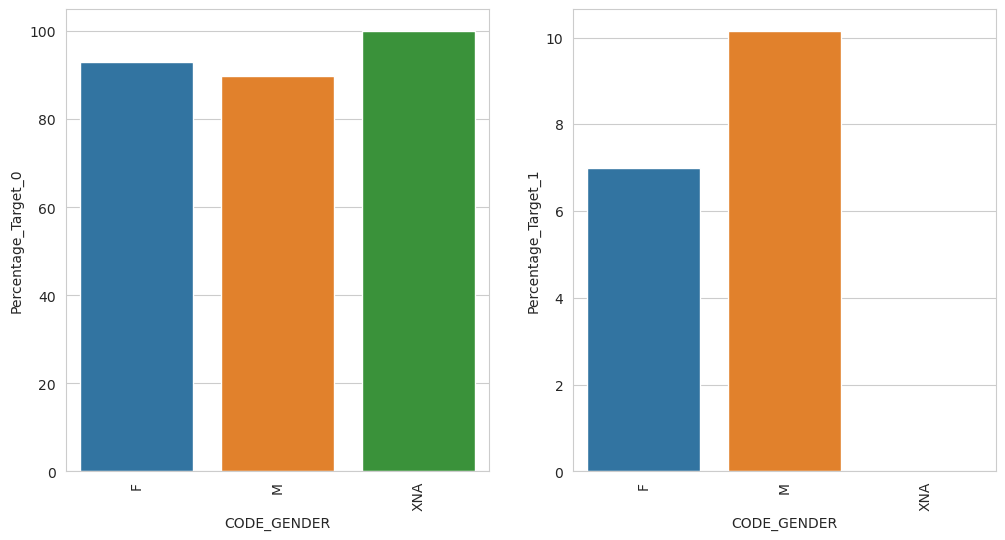

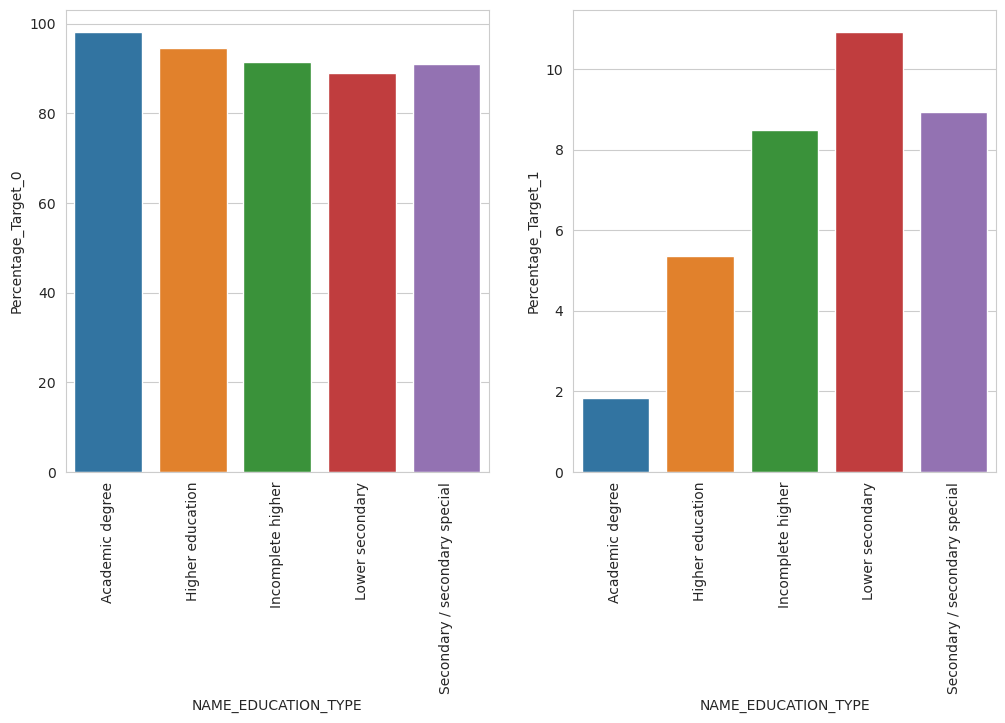

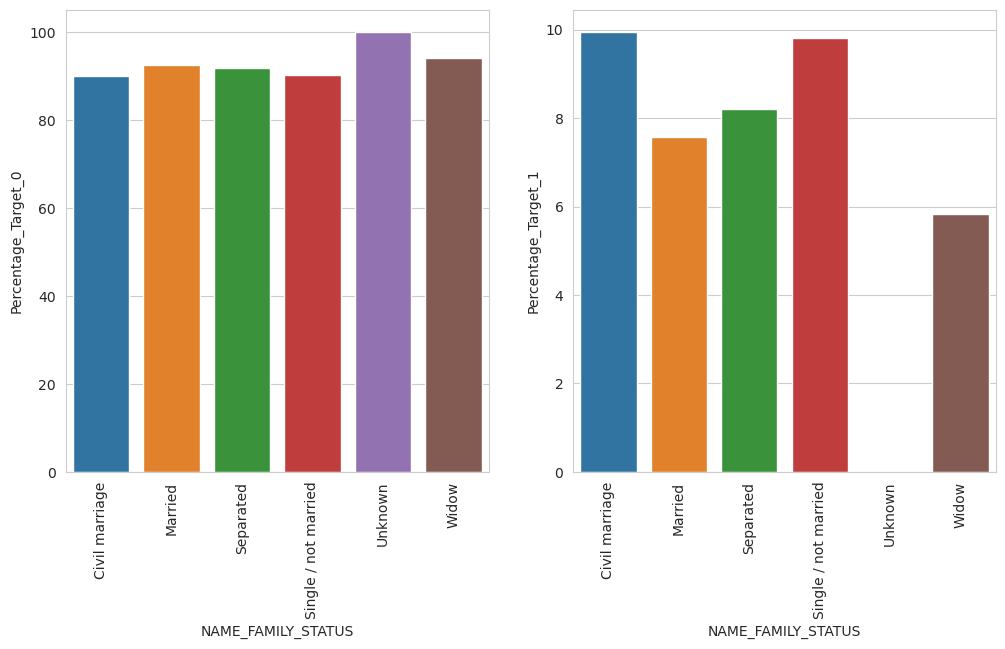

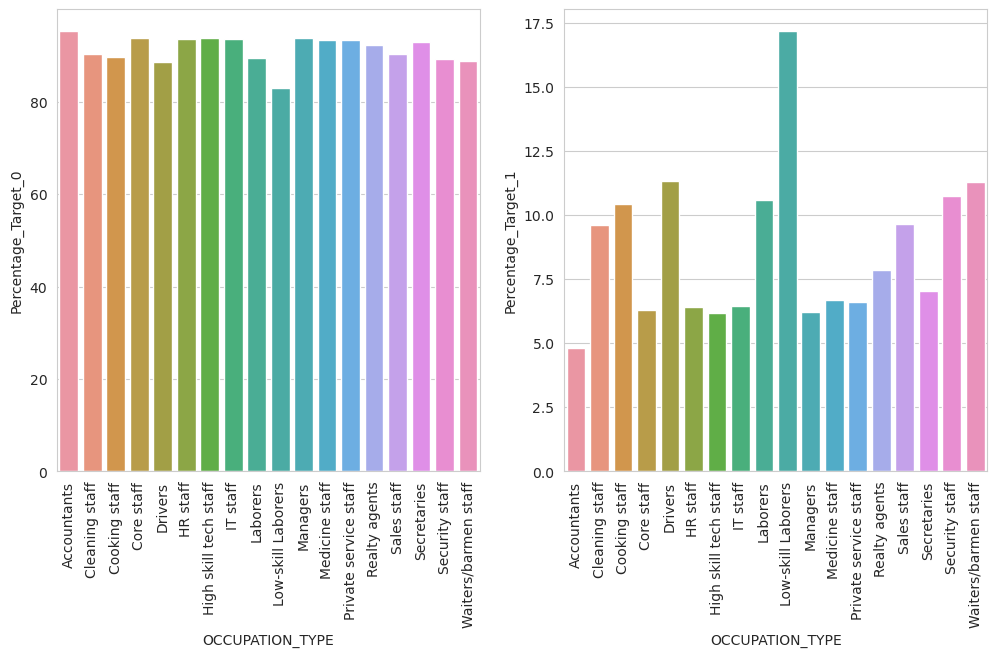

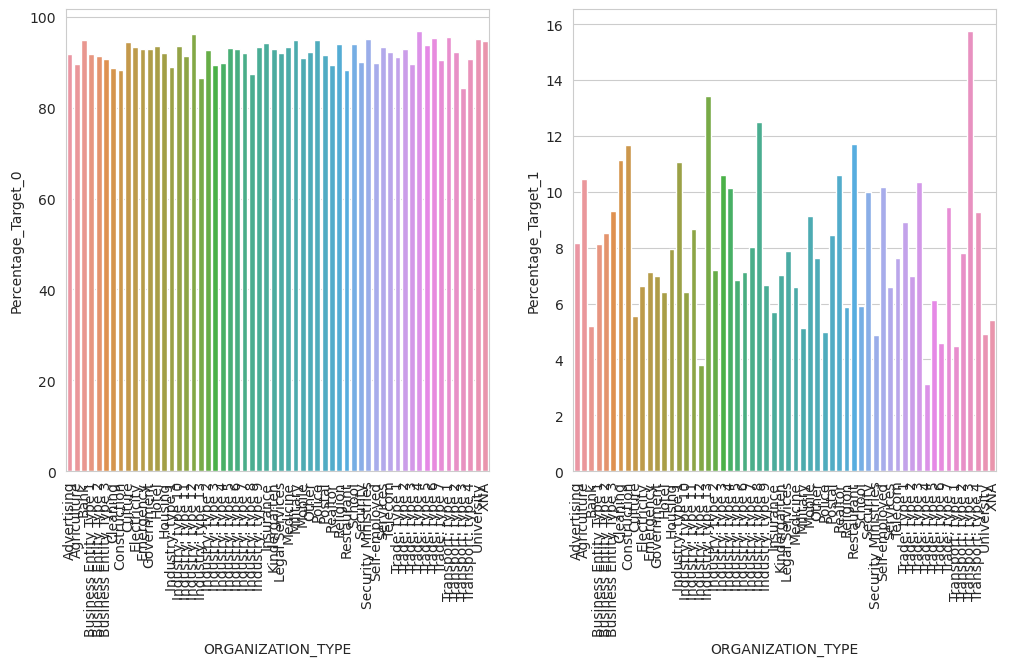

In [19]:

cat_stats(application_train,important_features)

### 2.5.3.Interpretation :

- for the first question, it seems that women are less defaulted than men and they are more repayable than men.So as a recommandation to the bank is to improve the procedure of repayment of loans given to men.<br>
- for the second question, poeple with a low education level shows the most defaulters ,in the first place people with less than secondary school. Also people with a hight education level are less prone to default. This feature show a significative difference of the distributions of defaulter and non defaulter so it will be helpfull for the modeling task.<br>
- for the third question, widow category are the least defaulder and the civil marriage category are the most defaulter category ,and this can be explained with the high amout of expences for families so they maight face problems in paying their annuity. <br>
- for the forth question ,the most likely category that defaults is the low labores and the less category to default is accountant ,this is very logic .Another finding from this plot is that the all categories have uniform destribution in the non defaulter set .

### 2.5.4.Chi_squired analysis :

We can employ the chi-squared test to compare the distributions of categorical features between groups, such as default and non-default. The chi-squared test assesses whether there is a statistically significant association between two categorical variables. By analyzing the test statistic and p-value, we can determine the strength of the relationship and the significance of the observed differences in the distributions.

In [20]:
# Perform chi-squared test
def chi2_test(df):
    chi2_stat_list=[]; p_val_list=[]; dof_list=[]; ex_list=[]
    for var in df.columns:
        chi2_stat, p_val, dof, ex = stats.chi2_contingency(pd.crosstab(application_train['TARGET'], application_train[var]))
        chi2_stat_list.append(chi2_stat); p_val_list.append(p_val); dof_list.append(dof); ex_list.append(ex);
    chi_squared=pd.DataFrame({'variable':df.columns,'dof':dof_list,'chi2_stat':chi2_stat_list,'p_val':p_val_list})
    chi_squared.set_index('variable',inplace=True)
    print(chi_squared.sort_values(by='p_val',ascending=True))

In [21]:
chi2_test(application_train.select_dtypes('O'))

                            dof    chi2_stat          p_val
variable                                                   
ORGANIZATION_TYPE            57  1609.240636  5.224541e-299
OCCUPATION_TYPE              17  1402.846796  3.784500e-288
NAME_INCOME_TYPE              7  1253.470808  1.928146e-266
NAME_EDUCATION_TYPE           4  1019.213187  2.447681e-219
CODE_GENDER                   2   920.791334  1.129022e-200
NAME_FAMILY_STATUS            5   504.694083  7.744842e-107
NAME_HOUSING_TYPE             5   420.556190   1.099089e-88
NAME_CONTRACT_TYPE            1   293.150542   1.023515e-65
FLAG_OWN_CAR                  1   146.656018   9.330994e-34
WALLSMATERIAL_MODE            6   139.235314   1.453180e-27
HOUSETYPE_MODE                2    27.632556   9.992328e-07
EMERGENCYSTATE_MODE           1    23.678150   1.138680e-06
NAME_TYPE_SUITE               6    32.825315   1.132931e-05
FLAG_OWN_REALTY               1    11.575827   6.681470e-04
FONDKAPREMONT_MODE            3    16.80

heyy! do you notice anything? the features that we assumed to be important are the same the most significative one .This garante our approach and strategy.<br>
More than inatial ones ,features such as **NAME_HOUSING_TYPE**, **FLAG_OWN_CAR** , **NAME_CONTRACT_TYPE** tends to be significatif and helpful.

### 2.5.5.Conclusion :


The findings from EDA guide the decisions and actions taken during the processing step, leading to improved data quality, better model performance, and more accurate and insightful results.Here the most usefull findings.<br>

**Issues with the data** :<br>
- data suffer from class imbalance .<br>
- missing values with different poportions .<br>
- outliers in many features .<br>
- numeric features with different scales .<br>
- 20 FLAG_DOCUMENT features with small impact,should be treated.<br>
- noisy features with small inpact to the target .<br>

**Insights may be helpfull** :<br>
- distribution plots and statistical tests (t_test and chi_squared) detect many relevant features ORGANIZATION_TYPE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,DAYS_BIRTH,REGION_RATING_CLIENT_W_CITY,<br>REGION_RATING_CLIENT,AMT_CREDIT.<br>
- defaulters are generally men with low education level , laborers and low skills, younger with recent employment and generally have higher score in the EXT_SOURCE rating and doesn't provide to the bank most of the twenty documents . As a recommandation ,Home Credit should be aware of this category of applicants.<br>
- Not repayed loans are qualified with small credit amount, high annuity .




# 3.Preprocessing + feature engineering:

The objective of the processing step in data analysis is to prepare the data for further modeling or analysis while addressing anomalies, inconsistencies, and challenges identified during the exploratory data analysis (EDA) phase. Processing the data is crucial as it ensures the data is in a suitable format, adheres to the assumptions of the chosen modeling techniques, and mitigates any issues that could adversely affect the accuracy and reliability of the results.

The findings from EDA serve as a guide for the processing step, providing insights into the patterns, relationships, and characteristics of the data. These insights help in determining the necessary data preprocessing steps,in our case: handling missing values, dealing with outliers, normalizing or scaling features, encoding categorical variables, or performing feature engineering.

## 3.1.Data Validation:

After performing exploratory data analysis (EDA), it is crucial to validate the data to ensure its quality, reliability, and consistency.In ur case we should remove the index column and replace some features to categorical ones.

In the given code snippet, we performed feature engineering on the application_train and application_test datasets. The steps involved dropping the 'SK_ID_CURR' column from both datasets, replacing anomalous values (365243) in the 'DAYS_EMPLOYED' column with NaN, and replacing 'XNA' values in the 'CODE_GENDER' column with NaN. These preprocessing steps ensure that the data is cleaned and prepared for further analysis and modeling.

In [22]:
application_train.drop('SK_ID_CURR',inplace=True,axis=1)
SK_ID_CURR=application_test['SK_ID_CURR']
application_test.drop('SK_ID_CURR',inplace=True,axis=1)
application_train['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)
application_test['DAYS_EMPLOYED'].replace(365243,np.nan,inplace=True)
application_train['CODE_GENDER'].replace('XNA',np.nan,inplace=True)
application_test['CODE_GENDER'].replace('XNA',np.nan,inplace=True)

Aggregating the 20 flag document features into a single feature by summing the number of flag documents per applicant can be a useful approach. By creating a new aggregated feature, we can capture the overall count or presence of flag documents for each applicant and reduce sparsity of the data, which may provide valuable information for the analysis or modeling task.

In [23]:
FLAG_DOCUMENT=['FLAG_DOCUMENT_2',
'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
'FLAG_DOCUMENT_21']
application_train['FLAG_DOCUMENT']=application_train[FLAG_DOCUMENT].sum(axis=1)
application_test['FLAG_DOCUMENT']=application_test[FLAG_DOCUMENT].sum(axis=1)
application_train.drop(FLAG_DOCUMENT,axis=1,inplace=True)
application_test.drop(FLAG_DOCUMENT,axis=1,inplace=True)


we should drop the **AMT_REQ_CREDIT** features because of they have no impact to the target and this may cause model missleading.

In [24]:
AMT_REQ_CREDIT=['AMT_REQ_CREDIT_BUREAU_HOUR','AMT_REQ_CREDIT_BUREAU_DAY',
                'AMT_REQ_CREDIT_BUREAU_WEEK','AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT']
application_train.drop(AMT_REQ_CREDIT,axis=1,inplace=True)
application_test.drop(AMT_REQ_CREDIT,axis=1,inplace=True)

 Two new features, **AGE** and **YEARS_EMPLOYED**, were created to provide additional information about the applicants' age and years of employment, respectively.<br> also **DEBT_TO_INCOME_RATIO**: This feature calculates the debt-to-income ratio by dividing the applicant's total credit amount by their total income.<br> 

In [25]:
# Age Feature
application_train['AGE']=application_train['DAYS_BIRTH']/(-365)
application_test['AGE']=application_test['DAYS_BIRTH']/(-365)
# MEAN_EXT_SOURCE
application_train['MEAN_EXT_SOURCE'] = application_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
application_test['MEAN_EXT_SOURCE'] = application_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
# Generate YEARS_EMPLOYED
application_train['YEARS_EMPLOYED']=application_train['DAYS_EMPLOYED']/(-365)
application_test['YEARS_EMPLOYED']=application_test['DAYS_EMPLOYED']/(-365)
# DAYS_BIRTH_SQUARED
application_train['DAYS_BIRTH_SQUARED'] = application_train['DAYS_BIRTH'] ** 2
application_test['DAYS_BIRTH_SQUARED'] = application_test['DAYS_BIRTH'] ** 2
# Generate DEBT_TO_INCOME_RATIO 
application_train['DEBT_TO_INCOME_RATIO'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
application_test['DEBT_TO_INCOME_RATIO'] = application_test['AMT_CREDIT'] / application_test['AMT_INCOME_TOTAL']
# Generate INCOME_TO_CREDIT 
application_train['INCOME_TO_CREDIT'] = application_train['AMT_INCOME_TOTAL'] / application_train['AMT_CREDIT']
application_test['INCOME_TO_CREDIT'] = application_test['AMT_INCOME_TOTAL'] / application_test['AMT_CREDIT']


In [26]:
new_numeric_features=['AGE','YEARS_EMPLOYED','DEBT_TO_INCOME_RATIO','INCOME_TO_CREDIT','DAYS_BIRTH_SQUARED']

In [27]:
t_test(application_train[new_numeric_features])

,variable,t_stat,p_val
0,AGE,43.519836,0.000000
1,DEBT_TO_INCOME_RATIO,4.284920,0.000018


 additional feature engineering was performed on both datasets. The following features were created based on patterns and analysis from EDA phase :

- **_INCOME_CLASS**: This feature categorizes the AMT_INCOME_TOTAL into three income classes: 'Low_INCOME', 'Medium_INCOME', and 'High_INCOME'.

- **ANNUITY_CLASS**: This feature divides the AMT_ANNUITY into three annuity classes: 'Low_ANNUITY', 'Medium_ANNUITY', and 'High_ANNUITY'.

- **AMT_GOODS_PRICE_0.2_0.7**: This binary feature indicates whether the AMT_GOODS_PRICE falls within the range of 20000 and 70000.

- **DAYS_BIRTH_CLASS**: This binary feature flags applicants with a DAYS_BIRTH value less than -15000, indicating older individuals.

- **CREDIT_UNDER_100K**: This binary feature identifies applicants with an AMT_CREDIT value below 100,000.

- **YEARS_EMPLOYED_CLASS**: This binary feature categorizes applicants based on their DAYS_EMPLOYED value, considering values less than 100,000.

In [28]:
application_train['_INCOME_CLASS']=pd.qcut(application_train['AMT_INCOME_TOTAL'],3,labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_train['ANNUITY_CLASS']=pd.qcut(application_train['AMT_ANNUITY'],3,labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
application_train['AMT_GOODS_PRICE_0.2_0.7']=np.where((application_train['AMT_GOODS_PRICE']<= 70000) & (application_train['AMT_GOODS_PRICE']>=20000) ,1,0)
application_train['DAYS_BIRTH_CLASS']=np.where(application_train['DAYS_BIRTH']<-15000,1,0)
application_train['CREDIT_UNDER_100K']=np.where(application_train['AMT_CREDIT']<100000,1,0)
application_train['YEARS_EMPLOYED_CLASS']=np.where(application_train['DAYS_EMPLOYED']<100000,1,0)

application_test['_INCOME_CLASS']=pd.qcut(application_test['AMT_INCOME_TOTAL'],3,labels=['Low_INCOME', 'Medium_INCOME', 'High_INCOME'])
application_test['ANNUITY_CLASS']=pd.qcut(application_test['AMT_ANNUITY'],3,labels=['Low_ANNUITY', 'Medium_ANNUITY', 'High_ANNUITY'])
application_test['AMT_GOODS_PRICE_0.2_0.7']=np.where((application_test['AMT_GOODS_PRICE']<= 7000) & (application_test['AMT_GOODS_PRICE']>=2000) ,1,0)
application_test['DAYS_BIRTH_CLASS']=np.where(application_test['DAYS_BIRTH']<-15000,1,0)
application_test['CREDIT_UNDER_100K']=np.where(application_test['AMT_CREDIT']<100000,1,0)
application_test['YEARS_EMPLOYED_CLASS']=np.where(application_test['DAYS_EMPLOYED']<100000,1,0)


In [29]:
new_categorical_features = ['_INCOME_CLASS','YEARS_EMPLOYED_CLASS','ANNUITY_CLASS',
                            'AMT_GOODS_PRICE_0.2_0.7','DAYS_BIRTH_CLASS','CREDIT_UNDER_100K']

Let's test the statistical significance of the relationship between the new categorical features and the target variable, providing insights into their potential importance in predicting the target variable of interest

In [30]:
chi2_test(application_train[new_categorical_features])

                         dof    chi2_stat          p_val
variable                                                
DAYS_BIRTH_CLASS           1  1344.950176  1.927723e-294
YEARS_EMPLOYED_CLASS       1   649.888509  2.362427e-143
ANNUITY_CLASS              2   157.760399   5.530502e-35
_INCOME_CLASS              2   152.501899   7.667140e-34
CREDIT_UNDER_100K          1    53.721017   2.310781e-13
AMT_GOODS_PRICE_0.2_0.7    1    34.102392   5.228696e-09


Based on the chi-squared test conducted on the new categorical features, the results indicate that several of these features exhibit a significant association with the target variable. The **DAYS_BIRTH_CLASS**, **ANNUITY_CLASS**, **_INCOME_CLASS**,**AMT_GOODS_PRICE_0.2_0.7**  and **CREDIT_UNDER_100K** features show statistically significant relationships with the target variable, as evidenced by their low p-values. This suggests that these features may be informative in predicting the target variable and can potentially be valuable in the modeling process. 

## 3.2.Handling Missing Data :

from the EDA **missing Data** represented in 67 columns and with different proportions from **0%** to **70%** ,and affects both numeric and categorical features.<br>
To tackle this problem our stragegy consists in :
- for numerical features we will remove features with highly missing proportion (more than 50%) and impute the rest using a robust strategy to outliers (median) .<br>
- for categorical features we will handle them in the encoding step by removing the dummy **NA** variable.

In [31]:
# Detect highly missing numeric features 
application_train_numeric= application_train.select_dtypes(include=['number'])
missings=application_train_numeric.loc[:,application_train_numeric.isna().mean() >= 0.6]
highly_missing_features = missings.columns
missings.columns

Index(['OWN_CAR_AGE', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'FLOORSMIN_AVG',
       'LIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_AVG', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'FLOORSMIN_MODE', 'LIVINGAPARTMENTS_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI',
       'FLOORSMIN_MEDI', 'LIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MEDI'],
      dtype='object')

In [32]:
#Remove highly missing features
application_train.drop(highly_missing_features,axis=1,inplace=True)
application_test.drop(highly_missing_features,axis=1,inplace=True)

In [33]:

target = application_train['TARGET']
features_train = application_train.drop('TARGET', axis=1)

# Impute numerical features using mean imputation
numeric_imputer = SimpleImputer(strategy='median')
numeric_features_train = features_train.select_dtypes(include='number')
imputed_numeric_features_train = numeric_imputer.fit_transform(numeric_features_train)
numeric_features_test = application_test.select_dtypes(include='number')
imputed_numeric_features_test = numeric_imputer.transform(numeric_features_test)

## 3.3.Encoding categorical data + remove missing categories:

We perform preprocessing on categorical features in the training and test datasets by appling one-hot encoding without generating binary feature for **NAN** modalities and then concatenates the encoded features with the imputed numerical features. This results in processed features ready for training and evaluation of machine learning models.

In [34]:
categorical_features_train = features_train.select_dtypes(include='object')
# using dummy_na=False ,we perform onehot encoding without affecting data distribution
dummy_categorical_features_train = pd.get_dummies(categorical_features_train,dummy_na=False)

# Concatenate imputed numerical and categorical features Train
imputed_features_train = pd.concat([pd.DataFrame(imputed_numeric_features_train, columns=numeric_features_train.columns),
                              dummy_categorical_features_train] ,axis=1)

# Impute categorical features Test using mode imputation and one-hot encoding

categorical_features_test = application_test.select_dtypes(include='object')
dummy_categorical_features_test = pd.get_dummies(categorical_features_test,dummy_na=False)

# Concatenate imputed numerical and categorical features
imputed_features_test = pd.concat([pd.DataFrame(imputed_numeric_features_test, columns=numeric_features_test.columns),
                              dummy_categorical_features_test],
                             axis=1)

In [35]:
imputed_features_train.drop('NAME_INCOME_TYPE_Maternity leave',axis=1,inplace=True)
imputed_features_train.drop('NAME_FAMILY_STATUS_Unknown',axis=1,inplace=True)


# 4.Model Building:

In the modeling step of this notebook, we aim to develop a predictive model for credit risk default. Building upon the insights gained from the exploratory data analysis (EDA) and processing phases, we will leverage various machine learning algorithms to predict the likelihood of default based on a range of relevant features. By employing advanced modeling techniques, we seek to improve our understanding of the factors that contribute to default and enhance our ability to identify high-risk borrowers.


## 4.1.Model Selection :


In the model selection step, we aim to choose the most suitable machine learning algorithm for our binary classification task. The goal is to identify a model that can effectively learn from the processed data and make accurate predictions on unseen data. To achieve this, we will evaluate multiple algorithms and compare their performance.

In [36]:
X=imputed_features_train.copy()
y=target
#splitting data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.25, random_state=27)


### 4.1.1 Simple estimators :

 we will begin by experimenting with simple estimators to get a baseline understanding of their performance on the given dataset. Simple estimators are often fast to train and provide a good starting point for comparison with more complex models.

In [36]:
# Define class weights
class_weights = {0: 1, 1: 9}

simple_estimators = {'Logistic Regression':LogisticRegression(),
                     'Decision Tree':DecisionTreeClassifier(),
                     'Linear Discriminant Analysys': LinearDiscriminantAnalysis()}

To runn this models we will apply the **SMOTE** oversampling technique to balance the classes in the training data,thenwe will scaele feature with **MinMaxScaler** this will improve the performance and speed up the training jobs Finally we will use **Recursive Feature Elimination (RFE)** to select the most important features for training the models. RFE is used to rank and select the relevant features based on the given model. The selected features are then used to train and test the model. The ROC AUC score is calculated and printed as a measure of model performance. By leveraging RFE, we aim to improve the model's predictive capabilities by focusing on the most informative features. 

In [40]:
def training_simple_models(estimators):
    for name, model in estimators.items():
        print("Running " + name)

        # Apply SMOTE oversampling to the training data
        smote = SMOTE()
        X_train_smt, y_train_smt = smote.fit_resample(X_train, y_train)
        
        # Scaling data
        scaler = MinMaxScaler()
        X_train_scaled= scaler.fit_transform(X_train_smt)
        X_test_scaled=scaler.transform(X_test)
        
        # Perform Recursive Feature Elimination (RFE)
        selector = RFE(estimator=model)
        X_train_selected = selector.fit_transform(X_train_scaled, y_train_smt)
        X_test_selected = selector.transform(X_test_scaled)
        
        # Train the model on the selected features
        model.fit(X_train_selected, y_train_smt)
        
        # Make predictions on the test data
        y_pred = model.predict_proba(X_test_selected)[:, 1]
        
        # Calculate and print the ROC AUC score
        roc_auc = roc_auc_score(y_test, y_pred)
        print("roc_auc:", roc_auc)
        print('*' * 20)


In [41]:
training_simple_models(simple_estimators)

Running Logistic Regression
roc_auc: 0.7331934774172184
********************
Running Decision Tree
roc_auc: 0.5369316971328731
********************
Running Linear Discriminant Analysys
roc_auc: 0.6829028158097165
********************


Here are the results of running the function on different models:

- Logistic Regression: ROC AUC score of 0.733 <br>
- Decision Tree: ROC AUC score of 0.537<br>
- Linear Discriminant Analysis: ROC AUC score of 0.683<br>
These scores indicate the performance of each model in terms of classification accuracy. A higher ROC AUC score indicates better model performance in distinguishing between the positive and negative classes. Based on these results, it appears that **Logistic Regression** has the highest performance among the three models. But Decision Tree may overfit so it's important to check with more CART models that can be less prone to overfit so in the next step we will explore the performance of **ensemble methods** .

### 4.1.2.Ensemble Methods :

After experimenting with simple estimators, the next step in the model selection process is to explore `ensemble methods`. `Ensemble methods `combine multiple base models to make predictions, leveraging the idea that combining the predictions of multiple models can often result in improved overall performance.

One popular `ensemble method` is the Random Forest algorithm. Random Forests build multiple decision trees using different subsets of the data and features, and then aggregate the predictions of each tree to make the final prediction. This technique helps to reduce overfitting and improve the generalization of the model.

Another ensemble method worth exploring is Gradient Boosting, which builds an ensemble of weak prediction models, such as decision trees, in a sequential manner. Each subsequent model is trained to correct the mistakes made by the previous models, gradually improving the overall performance. Gradient Boosting algorithms, such as XGBoost and LightGBM, have gained popularity for their ability to handle complex, high-dimensional datasets.

In [42]:

# Create an instance of the GradientBoostingClassifier class
clf = GradientBoostingClassifier(n_estimators=100, subsample=0.2, random_state=42, verbose = 1)

# Fit the model to the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict_proba(X_test)[:,1]
roc_GBC=roc_auc_score(y_test,y_pred)
print(roc_GBC)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5460           0.0105            1.15m
         2           0.5425           0.0074            1.13m
         3           0.5418           0.0058            1.11m
         4           0.5361           0.0049            1.11m
         5           0.5307           0.0037            1.09m
         6           0.5246           0.0029            1.09m
         7           0.5201           0.0025            1.08m
         8           0.5129           0.0019            1.06m
         9           0.5082           0.0017            1.05m
        10           0.5220           0.0015            1.04m
        20           0.5183           0.0005           55.18s
        30           0.4994           0.0005           48.31s
        40           0.5038           0.0003           41.42s
        50           0.5063           0.0001           34.38s
        60           0.4885           0.0001           27.48s
       

In [43]:

# Running Xgboost
# Define class weights
class_weights = {0: 1, 1: 9}

# Create an instance of the XGBClassifier class
xgb = XGBClassifier(n_estimators=100, subsample=0.4, random_state=1, scale_pos_weight=class_weights[1]/class_weights[0])

# Fit the model to the training data
xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb.predict_proba(X_test)[:,1]
roc_xgb=roc_auc_score(y_test,y_pred)
print(roc_xgb)

0.7275856305045889


In [44]:
# Running Random Forest 
rfc_100 = RandomForestClassifier(n_estimators=100, random_state=0)
rfc_100.fit(X_train, y_train)
y_pred_100 = rfc_100.predict_proba(X_test)[:,1]
print('Model auc score with 100 decision-trees : {0:0.4f}'. format(roc_auc_score(y_test, y_pred_100)))

Model auc score with 100 decision-trees : 0.7156


After exploring ensemble methods , you have obtained the following results:

- Gradient Boosting Classifier (GBC): ROC AUC score of 0.746<br>
- XGBoost Classifier (XGB): ROC AUC score of 0.728<br>
- Random Forest Classifier (RFC) with 100 decision trees: ROC AUC score of 0.716<br>
These results indicate the performance of each ensemble method in terms of classification accuracy. Based on these results, the **Gradient Boosting Classifier** achieved the highest ROC AUC score, followed by **XGBoost Classifier** and **Random Forest Classifier** with 100 decision trees.

# 5.Model Tuning:

Now after exploring many estimators, we perform a random search using RandomSearchCV to find the best hyperparameters for the to selected estimators **Logistic Regression** and **Gradient Boosting Classifier** . The objective is to optimize the model's performance based on the area under the ROC curve. The `param_grid` dictionary defines the hyperparameter grid with various values to explore. We use cross-validation to evaluate the model's performance robustly. After fitting the RandomSearchCV object, we print the best mean cross-validated score achieved and the corresponding best parameters. This approach automates the hyperparameter tuning process and helps identify the optimal configuration for the selected classifiers to enhance their performance.

## 5.1.Logistic Regression Tuning :

In order to tune the logistic regression with cross validation, we have created a pipeline using `Pipeline` . This pipeline consists of four steps: scaling the data using `MinMaxScaler`, applying SMOTE oversampling using `SMOTE`, performing Recursive Feature Elimination (RFE) using `RFE` with a logistic regression estimator, and training the logistic regression model.

We have defined a parameter grid that includes hyperparameters for RFE, SMOTE, and logistic regression. The hyperparameters include the number of features to select in RFE (`r__n_features_to_select`), the step size in RFE (`r__step`), the sampling strategy in SMOTE (`s__sampling_strategy`), the penalty in logistic regression (`m__penalty`), the regularization parameter in logistic regression (`m__C`), and the maximum number of iterations in logistic regression (`m__max_iter`).

This approach allows you to efficiently search for the best hyperparameters for logistic regression while incorporating SMOTE oversampling and RFE feature selection into the pipeline. The best LR model can then be used for further analysis or prediction tasks.

Feel free to let me know if you have any further questions or need more clarification!

In [37]:
from imblearn.pipeline import Pipeline



# Create the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('s', SMOTE(random_state=1)),
    ('r', RFE(estimator=LogisticRegression(random_state=1,max_iter=1000))),
    ('m', LogisticRegression(random_state=1))
])

# Define the parameter grid
param_grid = {
    'r__n_features_to_select': [40,50,70],  # RFE hyperparameter
    'r__step': [ 3,4,5],
    's__sampling_strategy': ['auto', 0.5, 1.0],  # SMOTE hyperparameter# RFE hyperparameter
    'm__penalty': ['l1', 'l2'],
    'm__C': [0.001,0.01, 0.1],
    'm__max_iter': [ 200, 300]
}

# Perform random search
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=1, random_state=1)
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings to sample
    scoring='roc_auc',
    cv=cv,
    verbose=0,# Evaluation metric
    n_jobs=cpu_count(),
    random_state=1
)

# Fit the random search to the data
random_search.fit(X_train, y_train)



NameError: name 'random_serch' is not defined

In [39]:
best_LR = random_search.best_estimator_
# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Best Parameters: {'s__sampling_strategy': 'auto', 'r__step': 5, 'r__n_features_to_select': 70, 'm__penalty': 'l2', 'm__max_iter': 300, 'm__C': 0.01}
Best Score: 0.7333525685636082


## 5.2.Gradient Boosting Tuning :


Now ,we will tune Gradient Boosting Classifier (GBC) using random search with cross-validation. The param_dist contains different hyperparameters for the GBC model, such as the number of estimators, maximum depth, minimum samples split, minimum samples leaf, maximum features, subsample, and learning rate.

A repeated stratified k-fold cross-validation is used for model evaluation. 

To handle class imbalance, sample weights are set based on the class labels (y_train) rather than using smote as in logistic regression it takes much time. A weight of 1 is assigned to class 0 (negative class), and a weight of 9 is assigned to class 1 (positive class). This is done to give more importance to the positive class during training .

In [70]:
# Tuning Gradient Boosting Classifier

param_dist = {
    'n_estimators': [50, 100, 200, 400],
    'max_depth': [10, 20, 30, 40, 50, 60],
    'min_samples_split': [5,10, 20, 30],
    'min_samples_leaf':[10, 20, 30, 40, 50, 60],
    'max_features': ['sqrt', 'log2', None],
    'subsample': [0.8, 0.9, 1.0],
    'learning_rate': [0.1, 0.01, 0.001]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
gbc = RandomizedSearchCV(GradientBoostingClassifier(),
                            param_distributions=param_dist,
                            n_iter=10,
                            cv=cv,
                            scoring='roc_auc',
                            random_state=1,
                            verbose=True,
                            n_jobs=cpu_count())

# Handle class imbalance by setting sample weights
sample_weights = [1 if label == 0 else 9 for label in y_train]

gbc.fit(X_train, y_train, sample_weight=sample_weights)
best_gbc = gbc.best_estimator_
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


NameError: name 'search' is not defined

In [73]:
best_gbc
print("Best parameter (CV score=%0.3f):" % gbc.best_score_)
print(gbc.best_params_)

Best parameter (CV score=0.749):
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 10, 'learning_rate': 0.01}


# 6.Model Evaluation :

The use of ROC curve and confusion matrix is essential for evaluating the performance of classification models. ROC curve helps visualize the trade-off between the true positive rate and false positive rate, providing insights into the model's discriminatory power, while the confusion matrix offers a detailed breakdown of the model's predictions, enabling assessment of its accuracy, precision, recall, and F1 score for different classes. These evaluation metrics aid in understanding the model's strengths and weaknesses, guiding decision-making and model improvement.

In [50]:
def roc_curve__confusion_matrix(model):
    from sklearn.metrics import roc_curve, auc
    y_prob_test = model.predict_proba(X_test)[:, 1]
    y_prob_train  = model.predict_proba(X_train)[:, 1]
    prediction=model.predict(X_test)
    # calculate tpr ,fpr
    fpr_test , tpr_test , thresholds = roc_curve(y_test, y_prob_test)
    fpr_train , tpr_train , thresholds1 = roc_curve(y_train, y_prob_train)

    # calculate AUC score
    roc_auc_test  = auc(fpr_test, tpr_test)
    roc_auc_train  = auc(fpr_train ,tpr_train)


    # calculate confusion matrix for test set
    confusion_matrix_test = confusion_matrix(y_test, prediction)

    # create subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # plot ROC curves on the first subplot
    axs[0].plot(fpr_train, tpr_train, color='green', label='ROC curve train (AUC = %0.2f)' % roc_auc_train)
    axs[0].plot(fpr_test, tpr_test, color='blue', label='ROC curve test (AUC = %0.2f)' % roc_auc_test)
    axs[0].plot([0, 1], [0, 1], color='red', linestyle='--')
    axs[0].set_xlabel('False Positive Rate')
    axs[0].set_ylabel('True Positive Rate')
    axs[0].set_title('Receiver Operating Characteristic (ROC) Curve')
    axs[0].legend(loc="lower right")

    sns.set(font_scale=1.4)
    sns.heatmap(confusion_matrix_test, annot=True, fmt='g', cmap='Blues', ax=axs[1])
    axs[1].set_xlabel('Predicted label')
    axs[1].set_ylabel('True label')
    axs[1].set_title('Confusion Matrix (Test Set)model');

    plt.tight_layout()
    plt.show()


## 6.1Logistic Regression Evaluation :

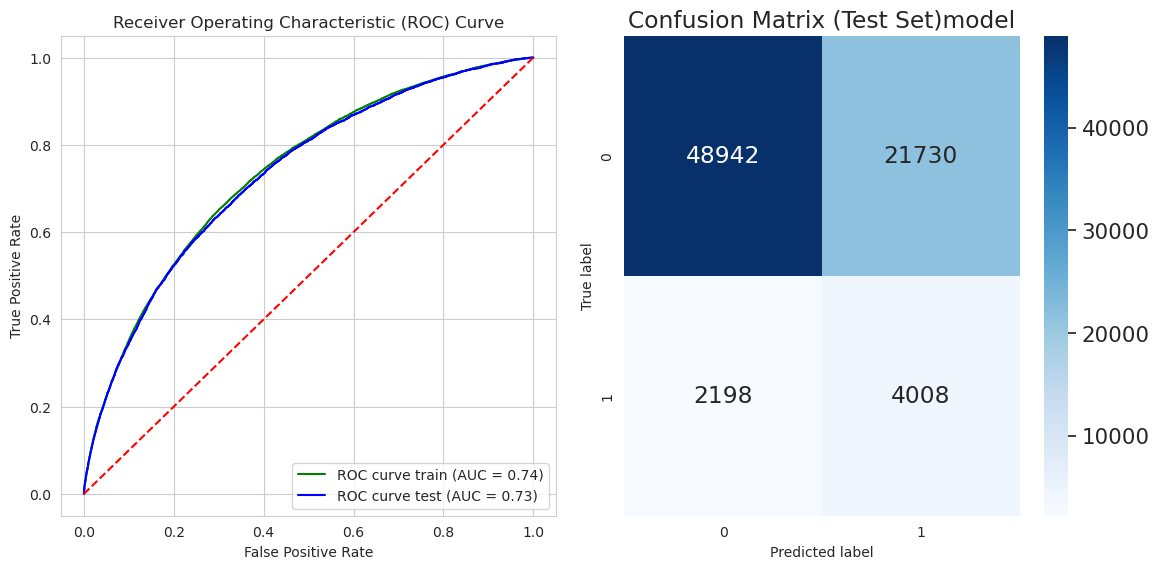

In [51]:
roc_curve__confusion_matrix(best_LR)

From the roc curve the model predicts both the train and test set by the same way (auc train=0.74 and auc test=0.73) so the is no prblem of overfitting . But from the evaluation with the confusion matrix the model doesn't perform well as we expect on the positive class(it missclassify 2198 from 6200) .The model doesn't improve the roc score after tuning because we used small number of iterations to check from a hyperparamter space contains hundreds of thousands of combinaision and this is because the big training time to run this huge number of models wich is time consuming and can take many days to complete .So if you like better performance you can run this code on the cloud ,this can be very fast.

## 6.2.Gradient Boosting Evaluation :

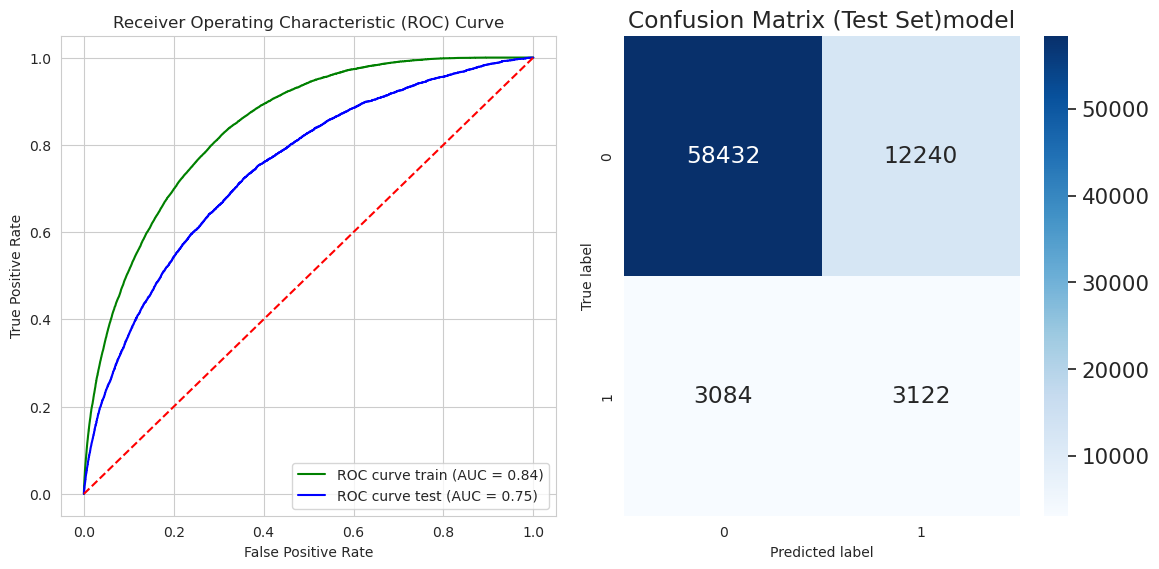

In [84]:
roc_curve__confusion_matrix(best_gbc)

The gradient boosting Classifier is overfitting the train set with a difference in auc 9% .And from the confution matrix we can say that Gradient Boosting performs better than logistic regression on the class 0(non defaulter) but give worst prediction to the positive class with a recall of 0.5 .<br> As we say to get better performance we should increase the number of itertion to check in th random search .

## 6.3.Features Importance:


Feature importance provides valuable insights into the relative contribution of each feature towards the model's predictions. By understanding feature importance, we can identify the most influential features that drive the model's performance and gain a deeper understanding of the underlying data patterns .

In [2]:
def feature_importance(model):  
    
    # Extract features importance from model
    importances = model.feature_importances_
    sorted_idx = importances.argsort()[::-1]
    feature_scores = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
    important_features=feature_scores[:10]
    
    # Creating a seaborn bar plot for features importance
    f, ax = plt.subplots(figsize=(30, 24))
    ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=feature_scores)
    ax.set_title("Visualize feature scores of the features")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(feature_scores.index)
    ax.set_xlabel("Feature importance score")
    ax.set_ylabel("Features")
    plt.show()
    print(important_features)


### 6.3.1.Gradient Boosting :

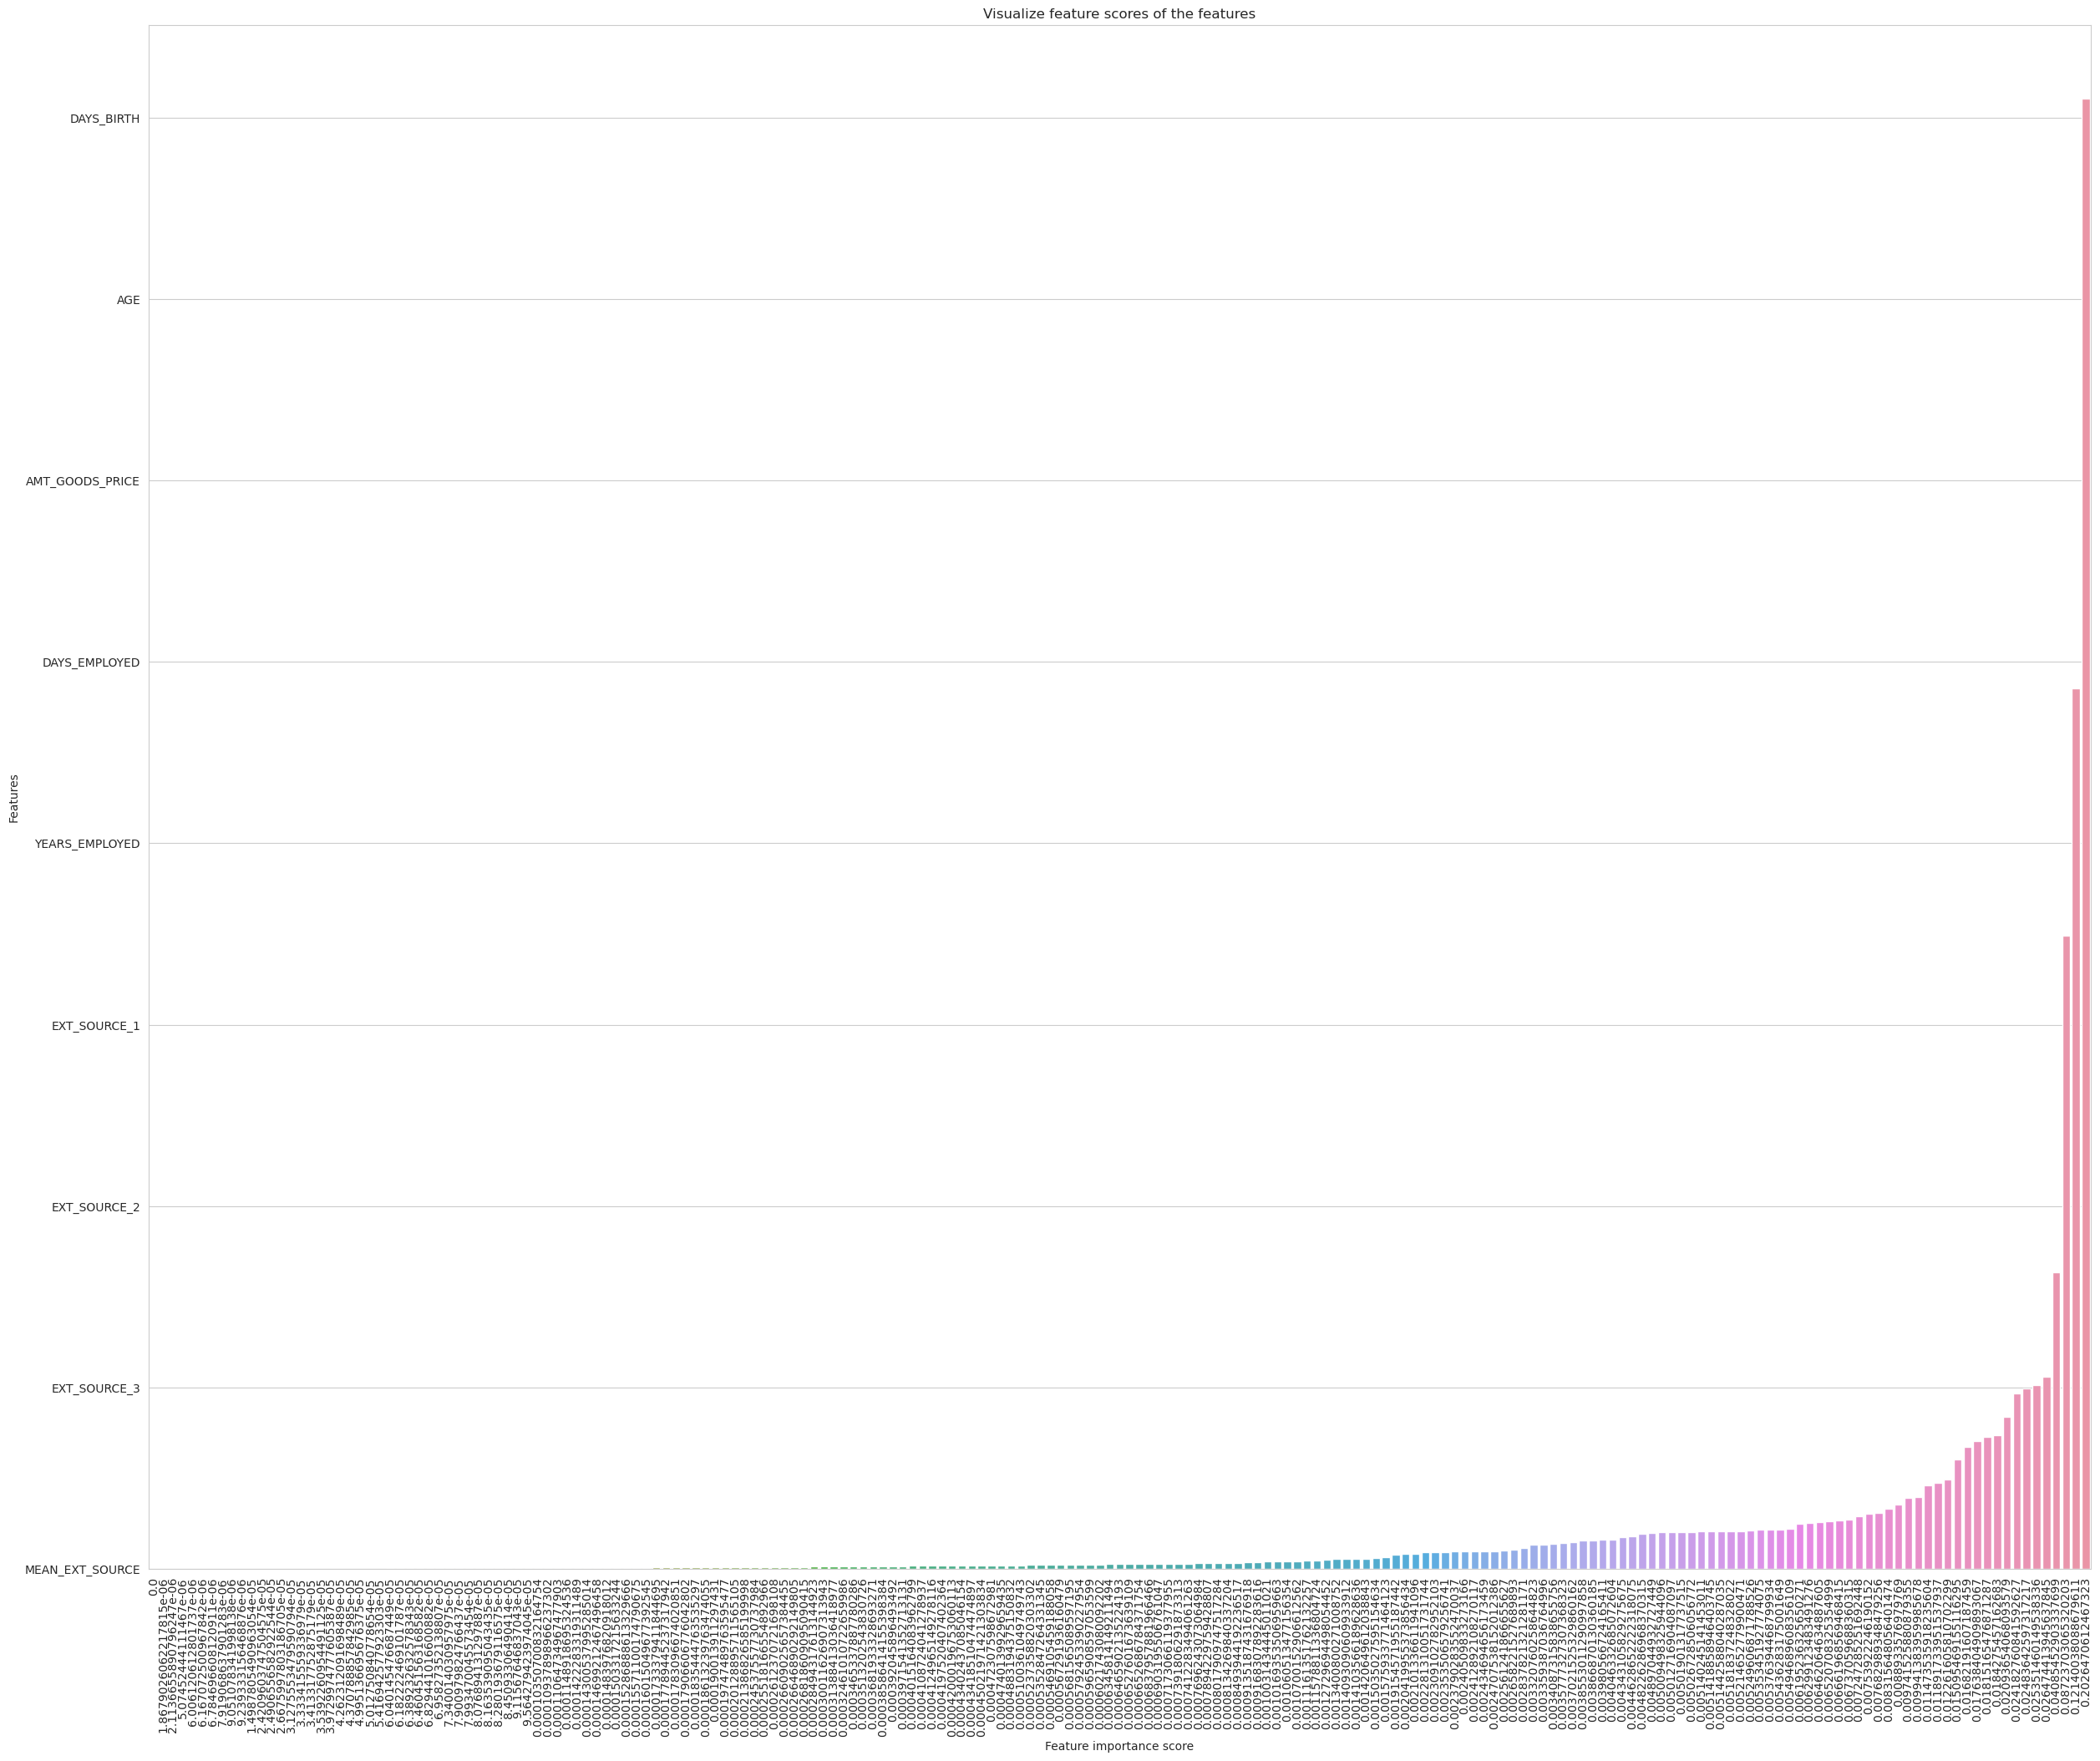

MEAN_EXT_SOURCE           0.202647
EXT_SOURCE_3              0.121400
EXT_SOURCE_2              0.087237
EXT_SOURCE_1              0.040855
YEARS_EMPLOYED            0.026474
DAYS_EMPLOYED             0.025351
AMT_GOODS_PRICE           0.024836
AGE                       0.024183
DAYS_BIRTH                0.020937
DAYS_LAST_PHONE_CHANGE    0.018428
dtype: float64


In [81]:
feature_importance(best_gbc)

The most predictive features are **MEAN_EXT_SOURCE** (that we have generated in the feature engineering section) ext sources 1,2 and 3 .also the generated features **YEARS_EMPLOYED** and **AGE** .So this make evidence that feature engineering is a powerful tool to improve the model as Andrew Ng says `applied machine learning is basically feature engineering` .

# 7.Submission :

In [58]:
# Make a submission for Logistic Regression
submit = application_test[['SK_ID_CURR']]
submit['TARGET'] = best_LR.predict_proba(imputed_features_test)[:,1]
submit.to_csv('submission_LR.csv', index = False)

this model score in the private leaderboard is **`0.713`** 

# 8.Conclusion :

We started our analysis with an Exploratory Data Analysis (EDA) phase, where we examined the dataset using summary statistics and visualizations to gain insights into the data distribution and identify any patterns or anomalies, also we test features relefance to the target using t_test and chi2_test. Based on the findings from EDA, we performed data preprocessing steps, which included handling missing values through dropping and imputation techniques, as well as addressing errors and anomalies in the data.

To enhance the predictive power of our models, we generated new features using domain knowledge and explored their relevance to the target variable. These new features were tested to ensure their effectiveness in capturing meaningful information.

Moving on to the modeling phase, we began by implementing a simple modeling approach using basic estimators. This allowed us to gauge the initial performance and understand the predictive power of the individual models. We then progressed to ensemble methods, specifically Random Forest ,GradientBoosting and XGBoost, which leverage the collective strength of multiple models. We fine-tuned these models using hyperparameter optimization technique Randomized Search, to find the optimal set of parameters that maximize the model's performance.

To evaluate the models, we visualized their performance using Receiver Operating Characteristic (ROC) curves, which illustrate the trade-off between true positive rate and false positive rate. Additionally, we analyzed the confusion matrices to assess the model's predictive accuracy in classifying the target variable.

Furthermore, we examined the importance of features in the models using feature importance techniques. This provided insights into the variables that significantly influenced the model's predictions and aided in understanding the underlying relationships in the data.

By following this comprehensive approach, we were able to extract valuable insights from the data, preprocess it effectively, build and optimize predictive models, and evaluate their performance using various metrics and visualizations. These findings and methodologies form the basis for our decision-making and feature engineering strategies in credit risk default analysis.

However, our exploration doesn't end here. In the upcoming notebooks, we will delve into additional dataframes available within the data schema to extract further insights and enhance the predictive power of our models.
Stay tuned for the upcoming notebooks, where we will embark on an exciting journey of exploration and refinement, ultimately striving to build a comprehensive and reliable credit risk prediction solution.

**Thanks for going all the way!**

<br>
Feel free to let me know if you have any further questions or need more clarification!


Did you enjoy reading this publication?
Show your appreciation for my work with an **`upvote`**.